In [2]:
# ================================
# Cell 1 — Functions (Goal1 + VQA)
# ================================
import os, re, time, math, pathlib, warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Qiskit (Estimator フォールバック)
try:
    from qiskit.primitives import Estimator as _Estimator
    ESTIMATOR_MODE = "V2"
except Exception:
    try:
        from qiskit_aer.primitives import Estimator as _Estimator
        ESTIMATOR_MODE = "V1"
    except Exception:
        _Estimator = None
        ESTIMATOR_MODE = "SV"

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Utils ----------
COLORS = {"true":"#1f77b4", "quantum":"#ff7f0e", "classical":"#d62728"}  # 青/橙/赤 固定（QRC互換）
def rmse_(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

class Timer:
    def __init__(self, label=""): self.label = label
    def __enter__(self): self.t0 = time.perf_counter(); return self
    def __exit__(self, *exc):
        if self.label:
            print(f"[TIMER] {self.label}: {time.perf_counter()-self.t0:.2f}s")

def ensure_outdir_missing():
    win_dir = r"C:\qiskit-python\QFF2025\outputs\Missing_QRC"
    posix_dir = "./outputs/Missing_QRC"
    outdir = win_dir if os.name == "nt" else posix_dir
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    print(f"[IO] Export directory = {outdir}")
    return outdir

def savefig_show(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[SAVE] {path}")
    plt.show()

def save_table(df: pd.DataFrame, path: str):
    pathlib.Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print(f"[SAVE] {path}")

# ---------- I/O ----------
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT = r"Maturity\s*:\s*([0-9.+\-eE]+)"

def read_swaption_any_with_mask(path: str):
    """CSV/Excel読込 → Date列抽出 → 数値化 → ffill/bfill → 観測マスク返却（QRC互換）。"""
    ext = os.path.splitext(path)[1].lower()
    if ext in (".xlsx", ".xls"):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path, engine="python", sep=None)

    # Date列推定（末尾優先）
    date_col = None
    for c in df.columns[::-1]:
        if str(c).strip().lower() == "date":
            date_col = c; break
    if date_col is None: date_col = df.columns[-1]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    feature_cols = [c for c in df.columns if c != date_col]
    df_num = df.copy()
    for c in feature_cols:
        if df_num[c].dtype == object:
            df_num[c] = df_num[c].astype(str).str.replace(",", ".")
    df_num[feature_cols] = df_num[feature_cols].apply(pd.to_numeric, errors="coerce")
    mask_obs = ~df_num[feature_cols].isna().values
    df_filled = df_num.copy()
    df_filled[feature_cols] = df_filled[feature_cols].ffill().bfill()
    return df_filled, date_col, feature_cols, mask_obs

# ---------- Tenor / Maturity ----------
def parse_tenor_maturity_from_headers(cols: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    T_list, M_list, bad = [], [], []
    for c in cols:
        s = str(c)
        m = re.search(HEADER_BIPAT, s)
        if m:
            t = float(m.group(1).strip(" ,;"))
            u = float(m.group(2).strip(" ,;"))
        else:
            m1 = re.search(TENOR_PAT, s); m2 = re.search(MATU_PAT, s)
            if m1 and m2:
                t = float(m1.group(1).strip(" ,;")); u = float(m2.group(1).strip(" ,;"))
            else:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
                if len(nums) >= 2: t, u = float(nums[0]), float(nums[1])
                else: t, u = np.nan, np.nan; bad.append(s)
        T_list.append(t); M_list.append(u)
    if bad:
        print(f"[WARN] Tenor/Maturity parse failed for {len(bad)} cols (up to 3 shown): {bad[:3]}")
    return np.array(T_list, float), np.array(M_list, float), np.arange(len(cols))

def _normalize_01(x: np.ndarray):
    x = np.asarray(x, float); mn, mx = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn: return np.zeros_like(x)
    return (x - mn)/(mx - mn)

def _normalize_pm1(x: np.ndarray):
    x = np.asarray(x, float); mn, mx = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn: return np.zeros_like(x)
    return 2.0*(x - mn)/(mx - mn) - 1.0

def build_phi_poly2(tenors: np.ndarray, maturities: np.ndarray, include_cross=True):
    """Φ(T,M) = [1, T, M, T^2, M^2, T·M]（T,Mは±1正規化）。"""
    Tn = _normalize_pm1(tenors); Mn = _normalize_pm1(maturities)
    parts, names = [np.ones_like(Tn), Tn, Mn, Tn**2, Mn**2], ["1","T","M","T2","M2"]
    if include_cross:
        parts.append(Tn*Mn); names.append("TxM")
    Phi = np.vstack(parts).T
    Phi[~np.isfinite(Phi)] = 0.0
    return Phi, names

# ---------- Scaler / PCA / 時系列ウィンドウ ----------
def fit_scaler(X_all: np.ndarray, cut_train_end: int):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    X_scaled_all = scaler.transform(X_all)
    return scaler, X_scaled_all

def pinv_colwise(Phi: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(Phi)

def project_to_beta(X_scaled_all: np.ndarray, A: np.ndarray) -> np.ndarray:
    """列方向の基底Φ(T,M)での射影係数（β）へ変換。"""
    return X_scaled_all @ A.T

def fit_pca_for_beta(beta_all: np.ndarray, cut_train_end: int, n_qubits: int):
    n_components_eff = min(n_qubits, beta_all.shape[1], max(1, beta_all[:cut_train_end].shape[0]-1))
    pca = PCA(n_components=n_components_eff, random_state=42).fit(beta_all[:cut_train_end])
    B_reduced_all = pca.transform(beta_all)
    return pca, B_reduced_all

def make_windows(X_any_all: np.ndarray, W: int) -> np.ndarray:
    out = [X_any_all[t-W:t] for t in range(W, len(X_any_all))]
    return np.asarray(out, float)  # (T-W, W, dim)

# ---------- 欠損マスク ----------
def build_holdout_mask_per_day(Obs_rows: np.ndarray, k_missing: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    N, F = Obs_rows.shape
    Hold = np.zeros((N, F), dtype=bool)
    for i in range(N):
        obs_idx = np.where(Obs_rows[i])[0].tolist()
        if len(obs_idx) == 0: continue
        rng.shuffle(obs_idx)
        k = min(k_missing, len(obs_idx))
        Hold[i, obs_idx[:k]] = True
    return Hold

# ---------- 同日GPR（Peer） ----------
def gpr_peer_from_observed_row(y_scaled_row: np.ndarray, obs_mask_row: np.ndarray,
                               tenors: np.ndarray, maturities: np.ndarray,
                               l_T=0.20, l_M=0.20, noise=1e-4, restarts=2) -> np.ndarray:
    """(T,M)座標の2次元GPRで同日観測セル→全面へ補間（QRC互換）。"""
    idx = np.where(obs_mask_row)[0]
    if len(idx) == 0:
        return np.full_like(y_scaled_row, float(np.nanmean(y_scaled_row)))
    Tn = _normalize_01(tenors); Mn = _normalize_01(maturities)
    X_obs = np.stack([Tn[idx], Mn[idx]], axis=1); y_obs = y_scaled_row[idx]
    X_all = np.stack([Tn, Mn], axis=1)
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[max(l_T,1e-3), max(l_M,1e-3)],
                                       length_scale_bounds=(1e-3, 10.0)) + WhiteKernel(noise_level=max(noise,1e-6))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True,
                                   n_restarts_optimizer=restarts, random_state=7)
    try:
        gpr.fit(X_obs, y_obs)
        y_hat = gpr.predict(X_all)
    except Exception:
        # RBF距離重みフォールバック
        D2 = ((X_all[:,None,:]-X_obs[None,:,:])**2)
        D2 = (D2[:,:,0]/(l_T*l_T)) + (D2[:,:,1]/(l_M*l_M))
        W = np.exp(-D2); Wsum = W.sum(axis=1, keepdims=True)+1e-12
        y_hat = (W @ y_obs.reshape(-1,1))/Wsum
        y_hat = y_hat.ravel()
    return y_hat

def coverage_confidence(obs_mask_row, tenors, maturities, l_T=0.25, l_M=0.25):
    """観測点からの距離に基づくカバレッジ指標 c∈(0,1]（QRC互換）。"""
    Tn = _normalize_01(tenors); Mn = _normalize_01(maturities)
    F = len(Tn); idx = np.where(obs_mask_row)[0]
    if len(idx) == 0: return np.zeros(F)
    X_obs = np.stack([Tn[idx], Mn[idx]], axis=1); X_all = np.stack([Tn, Mn], axis=1)
    D2 = ((X_all[:,None,:]-X_obs[None,:,:])**2)
    D2 = (D2[:,:,0]/(l_T*l_T)) + (D2[:,:,1]/(l_M*l_M))
    d2_min = np.min(D2, axis=1)
    c = np.exp(-d2_min)
    return c

def daywise_ab_from_obs(delta_true_row, delta_q_row, delta_peer_row, obs_for_fit, l2=1e-6, clip_ab=1.5):
    idx = np.where(obs_for_fit)[0]
    if len(idx) == 0: return 0.0, 0.0
    M = np.vstack([delta_q_row[idx], delta_peer_row[idx]]).T
    y = delta_true_row[idx]
    A = M.T @ M + l2*np.eye(2); b = M.T @ y
    try: ab = np.linalg.solve(A, b)
    except: ab = np.linalg.pinv(A) @ b
    a, bcoef = float(ab[0]), float(ab[1])
    return float(np.clip(a, -clip_ab, clip_ab)), float(np.clip(bcoef, -clip_ab, clip_ab))

def local_ab_for_cell(f: int, obs_for_fit_idx: np.ndarray,
                      delta_true_row: np.ndarray, delta_q_row: np.ndarray, delta_peer_row: np.ndarray,
                      tenors: np.ndarray, maturities: np.ndarray,
                      l_T=0.20, l_M=0.20, K=8, l2=1e-6, clip_ab=1.5, shrink=1.0):
    """(T,M)近傍K点での局所ブレンド係数 (a_f, b_f)。"""
    if obs_for_fit_idx.size == 0:
        return 0.0, 0.0
    Tn = _normalize_01(tenors); Mn = _normalize_01(maturities)
    x_f = np.array([Tn[f], Mn[f]])
    X_obs = np.stack([Tn[obs_for_fit_idx], Mn[obs_for_fit_idx]], axis=1)
    D2 = ((X_obs - x_f[None,:])**2); D2 = (D2[:,0]/(l_T*l_T)) + (D2[:,1]/(l_M*l_M))
    nn = np.argsort(D2)[:min(K, len(D2))]; ids = obs_for_fit_idx[nn]
    w = np.exp(-D2[nn])
    M = np.vstack([delta_q_row[ids], delta_peer_row[ids]]).T
    y = delta_true_row[ids]
    W = np.diag(w); A = M.T @ W @ M + l2*np.eye(2); b = M.T @ W @ y
    try: ab = np.linalg.solve(A, b)
    except: ab = np.linalg.pinv(A) @ b
    a, bcoef = float(np.clip(ab[0], -clip_ab, clip_ab)), float(np.clip(ab[1], -clip_ab, clip_ab))
    a *= shrink; bcoef *= shrink
    return a, bcoef

# ---------- Permutation（PrevDay vs Model） ----------
def permutation_pvalue_improvement(abs_err_prev: np.ndarray, abs_err_model: np.ndarray, n_perm=500, seed=7):
    """符号ランダム化の一側検定（改善>0）。QRC版の実装を踏襲。"""
    diffs = abs_err_prev - abs_err_model
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size == 0: return np.nan
    rng = np.random.default_rng(seed); obs_mean = np.mean(diffs); cnt = 0
    for _ in range(n_perm):
        signs = rng.choice([-1.0, 1.0], size=diffs.size)
        pseudo = diffs * signs
        if np.mean(pseudo) >= obs_mean: cnt += 1
    pval = (cnt + 1) / (n_perm + 1)
    return float(pval)

# ---------- 可視化（QRC互換の色） ----------
def line_overlay_triple(dates, true_y, quantum_y, classical_y,
                        labels=("True","Quantum (VQA Δ→level)","Classical (PrevDay)"),
                        title="", out_png=None):
    plt.figure(figsize=(10,4))
    plt.plot(dates, true_y, label=labels[0], color=COLORS["true"])
    plt.plot(dates, quantum_y, label=labels[1], color=COLORS["quantum"])
    plt.plot(dates, classical_y, label=labels[2], color=COLORS["classical"])
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend()
    if out_png: savefig_show(out_png)
    else: plt.show()

def heatmap_by_grid(values_1d, feature_cols, title, center_zero=False):
    from collections import defaultdict
    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    valid = np.isfinite(tenors) & np.isfinite(maturities)
    v = np.asarray(values_1d)[valid]
    T_v = np.round(tenors[valid], 12); M_v = np.round(maturities[valid], 12)
    idx_by_pair = defaultdict(list)
    for i, (t, m) in enumerate(zip(T_v, M_v)): idx_by_pair[(float(t), float(m))].append(i)
    unique_pairs = sorted(idx_by_pair.keys())
    T_vals = sorted({t for (t, _) in unique_pairs})
    M_vals = sorted({m for (_, m) in unique_pairs})
    if len(T_vals)*len(M_vals) != len(unique_pairs) or len(T_vals)==0 or len(M_vals)==0:
        plt.figure(figsize=(8,2)); plt.plot(v); plt.title(title+" (flat)"); plt.grid(True); return
    pos_T = {t: i for i,t in enumerate(T_vals)}; pos_M = {m: i for i,m in enumerate(M_vals)}
    mat = np.zeros((len(T_vals), len(M_vals)))
    for (t,m), ids in idx_by_pair.items(): mat[pos_T[t], pos_M[m]] = float(np.mean(v[ids]))
    plt.figure(figsize=(5,4))
    im = plt.imshow(mat, aspect='auto')
    if center_zero:
        cmax = np.max(np.abs(mat)); im.set_clim(-cmax, cmax)
    plt.title(title); plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.colorbar()

# ---------- Δキャップ（列別MAD×q） ----------
def cap_delta_cols(delta_2d: np.ndarray, q=2.5):
    """列ごとのMAD×qでΔをクリップ（学習・推論の両方で利用可）。"""
    X = np.asarray(delta_2d, float)
    med = np.nanmedian(X, axis=0)
    mad = np.nanmedian(np.abs(X - med), axis=0) + 1e-12
    cap = q * 1.4826 * mad
    return np.clip(X, -cap, +cap), cap

# ---------- VQA 入力前処理（X→n_qubits, ΔY→ky） ----------
@dataclass
class VQATransforms:
    X_scaler: StandardScaler
    X_pca: PCA          # → n_qubits
    Y_scaler: StandardScaler
    Y_pca: PCA          # → ky
    n_qubits: int
    ky: int

def fit_transforms_for_vqa(X_vec_tr: np.ndarray, Y_delta_tr: np.ndarray, n_qubits: int, ky: int) -> VQATransforms:
    # X: 標準化→PCAで n_qubits 次元（角度エンコードのレンジ安定のため±3σに後でクリップ）
    Xs = StandardScaler().fit(X_vec_tr)
    Xz = Xs.transform(X_vec_tr)
    pX = PCA(n_components=min(n_qubits, Xz.shape[1]), random_state=0).fit(Xz)

    # Y(Δ): 標準化→PCAで ky 次元（多出力を圧縮して学習安定化）
    Ys = StandardScaler().fit(Y_delta_tr)
    Yz = Ys.transform(Y_delta_tr)
    pY = PCA(n_components=min(ky, Yz.shape[1]), random_state=0).fit(Yz)

    return VQATransforms(X_scaler=Xs, X_pca=pX, Y_scaler=Ys, Y_pca=pY, n_qubits=n_qubits, ky=ky)

def transform_X_to_qubits(X_vec: np.ndarray, tr: VQATransforms) -> np.ndarray:
    Xz = tr.X_scaler.transform(X_vec)
    Xb = tr.X_pca.transform(Xz)  # (N, n_qubits)
    return np.clip(Xb, -3.0, 3.0) # ±3σ内→角度はπ/6程度に

def transform_Ydelta_to_ky(Y_delta: np.ndarray, tr: VQATransforms) -> np.ndarray:
    Yz = tr.Y_scaler.transform(Y_delta)
    return tr.Y_pca.transform(Yz)

def inverse_from_ky(Ybar: np.ndarray, tr: VQATransforms) -> np.ndarray:
    return tr.Y_scaler.inverse_transform(tr.Y_pca.inverse_transform(Ybar))

# ---------- 角度エンコード ----------
def angle_encode_ry(qc: QuantumCircuit, xvec: np.ndarray, scale: float = math.pi/6):
    # 入力は±3σにクリップ済み→角度は最大で±π/2以内程度
    angles = scale * xvec
    for q, a in enumerate(angles):
        qc.ry(float(a), q)

# ---------- VQA（HW-efficient + RY/RZ + Ring entangle + reupload） ----------
class VQARegressor:
    """
    - 入力: xbar (n_qubits)   ※W日の情報は前処理で集約
    - 回路: [ RY(x) → {RY(θ), RZ(θ)}×depth + リングエンタングル ] × reupload
    - 出力: 観測Zのうち ky 個（readout_qubits）を特徴Zにし、線形ヘッド(Ridge)で Ybar(ky) を回帰
    - 学習: SPSA（パラメタはθのみ）、ヘッドは各反復で閉形式更新（Ridge）
    """
    def __init__(self, n_qubits: int, ky: int, depth: int=2, reupload: int=2, seed: int=7):
        assert ky <= n_qubits, "ky must be <= n_qubits"
        self.n_qubits, self.ky, self.depth, self.reupload = n_qubits, ky, depth, max(1, int(reupload))
        self.readout_qubits = list(range(ky))
        self.estimator_mode = ESTIMATOR_MODE
        self.estimator = _Estimator() if _Estimator is not None else None
        self.rng = np.random.default_rng(seed)
        # 2パラメタ（RY,RZ）×各層×各qubit×reupload
        self.n_params = 2 * n_qubits * depth * self.reupload
        self.theta = self.rng.normal(0, 0.05, size=self.n_params)

    def _entangle_ring(self, qc: QuantumCircuit):
        n = self.n_qubits
        for i in range(n - 1):
            qc.cx(i, i+1)
        qc.cx(n-1, 0)

    def _build_circuit_for_x(self, xbar: np.ndarray, theta: np.ndarray) -> QuantumCircuit:
        qc = QuantumCircuit(self.n_qubits)
        # reupload回：毎回RY(x)で再注入 → [RY,RZ]層 + リングCNOT
        idx = 0
        for _ in range(self.reupload):
            angle_encode_ry(qc, xbar, scale=math.pi/6)
            for _ in range(self.depth):
                for q in range(self.n_qubits):
                    qc.ry(theta[idx], q); idx += 1
                    qc.rz(theta[idx], q); idx += 1
                self._entangle_ring(qc)
        return qc

    def _observables_Z(self):
        # little-endianに注意してZを定義
        obs = []
        for q in self.readout_qubits:
            pauli = ['I']*self.n_qubits
            pauli[self.n_qubits-1-q] = 'Z'
            from qiskit.quantum_info import SparsePauliOp
            obs.append(SparsePauliOp.from_list([(''.join(pauli), 1.0)]))
        return obs

    def _predict_features(self, Xbar: np.ndarray, theta: Optional[np.ndarray]=None, for_training: bool=False) -> np.ndarray:
        theta = theta if theta is not None else self.theta
        obs = self._observables_Z()
        outs = []
        for x in Xbar:
            qc = self._build_circuit_for_x(x, theta)
            if for_training or (self.estimator is None):
                sv = Statevector.from_instruction(qc)
                vals = [float(np.real(sv.expectation_value(o))) for o in obs]
            elif self.estimator_mode == "V2":
                res = self.estimator.run([(qc, obs)]).result()
                vals = np.array(res.values, dtype=float).reshape(-1).tolist()
            else:  # V1
                job = self.estimator.run([qc]*len(obs), obs)
                vals = np.array(job.result().values, dtype=float).reshape(-1).tolist()
            outs.append(vals)
        return np.array(outs)  # (N, ky)

    def predict_batch(self, Xbar: np.ndarray, theta: Optional[np.ndarray]=None) -> np.ndarray:
        return self._predict_features(Xbar, theta, for_training=False)

    def spsa_fit(self, Xbar_train, Ybar_train, Xbar_val=None, Ybar_val=None,
                 maxiter=300, a=0.25, c=0.08, alpha=0.602, gamma=0.101,
                 batch_size=32, seed=7, verbose=1, patience=40, min_delta=1e-6):
        """SPSAでθを更新（ヘッドは各反復でRidge閉形式）。VQA回帰ノートの流儀に準拠。"""
        rng = np.random.default_rng(seed)
        N = Xbar_train.shape[0]
        hist = {"train": [], "val": []}
        best_val = float("inf"); stall = 0

        def mse_via_head(th, xb, yb):
            Z = self._predict_features(xb, th, for_training=True)
            head = Ridge(alpha=1e-6, fit_intercept=True).fit(Z, yb)
            yhat = head.predict(Z)
            return float(np.mean((yhat - yb)**2)), head

        t0 = time.perf_counter()
        for k in range(1, maxiter+1):
            idx = rng.choice(N, size=min(batch_size, N), replace=False)
            xb, yb = Xbar_train[idx], Ybar_train[idx]
            ak = a / (k**alpha)
            ck = c / (k**gamma)
            delta = rng.choice([-1.0, 1.0], size=self.theta.shape)

            th_plus  = self.theta + ck*delta
            th_minus = self.theta - ck*delta
            Lp, _ = mse_via_head(th_plus,  xb, yb)
            Lm, _ = mse_via_head(th_minus, xb, yb)
            gk = (Lp - Lm) / (2.0*ck) * delta
            self.theta = self.theta - ak * gk

            trL, head_now = mse_via_head(self.theta, xb, yb)
            if Xbar_val is not None and Ybar_val is not None and len(Xbar_val)>0:
                Zva = self._predict_features(Xbar_val, self.theta, for_training=True)
                vaL = float(np.mean((head_now.predict(Zva) - Ybar_val)**2))
            else:
                vaL = np.nan

            hist["train"].append(trL); hist["val"].append(vaL)
            if verbose and (k == 1 or k % 25 == 0 or k == maxiter):
                print(f"[SPSA] iter {k}/{maxiter} - train={trL:.6f}, val={vaL:.6f}")

            if not np.isnan(vaL):
                if vaL + min_delta < best_val:
                    best_val = vaL; stall = 0
                else:
                    stall += 1
                if stall >= patience:
                    if verbose:
                        print(f"[EARLY STOP] no val improvement for {patience} iters (best_val={best_val:.6f})")
                    break

        t1 = time.perf_counter()
        print(f"[TIMER] SPSA training = {t1 - t0:.2f} sec")
        return hist

# ---------- VQA用の特徴作成（QRC下地に準拠） ----------
def prepare_vqa_features(df: pd.DataFrame, date_col: str, feature_cols: List[str],
                         mask_obs: np.ndarray, W: int, apply_log1p: bool,
                         n_qubits: int, cut_train_end: int):
    """
    1) ログ/スケーリング → 2) Φ(T,M)で列方向を射影（β） → 3) PCAでn_qubits次元 → 4) Wウィンドウを集約
    → Xbar_all（各日1ベクトル）を生成。Y/Prevはスケール空間で返す。
    """
    X_raw = df[feature_cols].values.astype(float)
    X_all = np.log1p(X_raw) if apply_log1p else X_raw.copy()

    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    Phi, _ = build_phi_poly2(tenors, maturities, include_cross=True)
    A = pinv_colwise(Phi)
    scaler_X, X_scaled_all = fit_scaler(X_all, cut_train_end)
    beta_all = project_to_beta(X_scaled_all, A)
    pca_beta, B_reduced_all = fit_pca_for_beta(beta_all, cut_train_end, n_qubits)

    # Wウィンドウ（平均で集約→reuploadは回路側で再注入）
    windows_r_all = make_windows(B_reduced_all, W)   # (T-W, W, nq_eff)
    Xbar_all = windows_r_all.mean(axis=1)            # (T-W, nq_eff)

    Obs_all = mask_obs[W:]                           # (T-W, F)
    dates_feat = pd.to_datetime(df[date_col].values)[W:]
    X_scaled_full = X_scaled_all

    return {
        "Phi": Phi, "A": A, "pca_beta": pca_beta, "scaler_X": scaler_X,
        "B_reduced_all": B_reduced_all, "Xbar_all": Xbar_all,
        "Obs_all": Obs_all, "dates_feat": dates_feat,
        "X_scaled_full": X_scaled_full
    }


In [3]:
# ================================
# Cell 2 — Train & Evaluate (VQA Δ→level; GPR peer; day×seed eval)
# ================================
OUTDIR = ensure_outdir_missing()
print(f"[ENV] estimator_mode = {ESTIMATOR_MODE}")

# ---- User params ----
DATA_PATH = r"C:\qiskit-python\QFF2025\Dataset_Simulated_Price_swaption.csv"  # CSV/Excel
APPLY_LOG1P = True

# Window & VQA
W = 20
N_QUBITS = 10
KY = 6
DEPTH = 3
REUPLOAD = 2
SPSA_ITERS = 400
SPSA_PATIENCE = 40
BATCH_SIZE = 32
SEED = 7

# Holdout & target days
TARGET_MODE = "auto"             # "auto" or "manual"
TARGET_N_DAYS = 5
TARGET_DATES_MANUAL = []         # 例: ["2052-01-01", ...]
MISSING_PER_DAY = 14
EVAL_SEEDS = [7, 11, 19]         # ランダム欠損モード時のseed

# GPR peer & blend
RBF_L_T = 0.20; RBF_L_M = 0.20; RBF_NOISE = 1e-4; RBF_RESTARTS = 2
COV_L_T = 0.25; COV_L_M = 0.25   # coverage
K_NN = 8
L2_AB = 1e-6
CLIP_AB = 1.5
SHRINK_GAMMA = 1.0               # coverage^gamma

# Goal 1 thresholds
PASS_FRAC_DAYS = 0.80
PASS_MEAN_IMPR_PCT = 0.05    # 5%
PASS_PVAL = 0.05

# ---- Load ----
df, DATE_COL, feature_cols, mask_obs = read_swaption_any_with_mask(DATA_PATH)
dates_all = pd.to_datetime(df[DATE_COL].values)
X_raw_full = df[feature_cols].values.astype(float)
T, F = X_raw_full.shape
print(f"[DATA] T={T}, F={F}, DATE_COL='{DATE_COL}'")

# ---- Prepare features for VQA ----
cut_train_end_dummy = max(W+1, int(T*0.7))
prep = prepare_vqa_features(df, DATE_COL, feature_cols, mask_obs, W, APPLY_LOG1P,
                            n_qubits=N_QUBITS, cut_train_end=cut_train_end_dummy)
Xbar_all = prep["Xbar_all"]                 # (T-W, nq_eff)
Obs_all = prep["Obs_all"]                   # (T-W, F)
dates_feat = prep["dates_feat"]
X_scaled_full = prep["X_scaled_full"]

# スケール空間の series を作る
Y_scaled = X_scaled_full[W:]                # (T-W, F)
base_prev_scaled = X_scaled_full[W-1:T-1]   # (T-W, F)
Y_target_delta = Y_scaled - base_prev_scaled

# ---- Target days ----
def choose_target_days(dates_feat, Obs_all, mode="auto", manual_dates=None, n_days=1):
    if (manual_dates is not None) and (mode=="manual"):
        s_to_idx = {pd.Timestamp(d): i for i, d in enumerate(dates_feat)}
        out = [s_to_idx.get(pd.Timestamp(d)) for d in manual_dates]
        out = [i for i in out if i is not None]
        return out[:max(1, n_days)]
    cand = [i for i in range(len(dates_feat)) if (~Obs_all[i]).any()]
    if not cand: cand = list(range(len(dates_feat)-n_days, len(dates_feat)))
    return sorted(cand[:max(1, n_days)])

target_rows = choose_target_days(dates_feat, Obs_all,
                                 mode=("manual" if TARGET_MODE.lower()=="manual" else "auto"),
                                 manual_dates=[pd.Timestamp(d) for d in TARGET_DATES_MANUAL],
                                 n_days=int(TARGET_N_DAYS))
assert len(target_rows) >= 1, "No target day found."
print("[TARGET DAYS]", [str(dates_feat[i].date()) for i in target_rows])

# ---- Train/Val split（評価日を除く）----
all_rows = np.arange(len(dates_feat))
train_rows_all = np.array([i for i in all_rows if i not in set(target_rows)], dtype=int)
n_tr = int(len(train_rows_all)*0.85)
idx_tr_rows = train_rows_all[:n_tr]
idx_va_rows = train_rows_all[n_tr:]

# ---- Δキャップ（列別MAD）を学習区間で推定 ----
delta_tr = Y_target_delta[idx_tr_rows]
_, DELTA_CAP_VEC = cap_delta_cols(delta_tr, q=2.5)  # 推奨 q=2.5

# ---- VQA transforms（X→n_qubits, ΔY→ky）----
X_vec_tr = Xbar_all[idx_tr_rows]
Y_delta_tr = np.clip(delta_tr, -DELTA_CAP_VEC, +DELTA_CAP_VEC)
tr_vqa = fit_transforms_for_vqa(X_vec_tr, Y_delta_tr, n_qubits=N_QUBITS, ky=KY)
Xb_tr = transform_X_to_qubits(Xbar_all[idx_tr_rows], tr_vqa)
Xb_va = transform_X_to_qubits(Xbar_all[idx_va_rows], tr_vqa)
Xb_all = transform_X_to_qubits(Xbar_all, tr_vqa)

Yb_tr = transform_Ydelta_to_ky(Y_target_delta[idx_tr_rows], tr_vqa)
Yb_va = transform_Ydelta_to_ky(Y_target_delta[idx_va_rows], tr_vqa)

# ---- VQA model ----
vqa = VQARegressor(n_qubits=tr_vqa.n_qubits, ky=tr_vqa.ky,
                   depth=DEPTH, reupload=REUPLOAD, seed=SEED)

# ---- SPSA training (θのみ最適化；ヘッドは各反復で閉形式) ----
hist = vqa.spsa_fit(Xb_tr, Yb_tr, Xb_va, Yb_va,
                    maxiter=SPSA_ITERS, batch_size=BATCH_SIZE,
                    patience=SPSA_PATIENCE, seed=SEED, verbose=1)

# ---- Final head（Ridge; 全trainでfit）→ 予測（全期間）----
Z_tr = vqa.predict_batch(Xb_tr)
head = Ridge(alpha=1e-6, fit_intercept=True).fit(Z_tr, Yb_tr)

Z_all = vqa.predict_batch(Xb_all)
Yb_hat_all = head.predict(Z_all)                              # ky空間のΔ
delta_hat_scaled_all = inverse_from_ky(Yb_hat_all, tr_vqa)    # スケール空間Δ (T-W, F)
# Δキャップを適用
delta_hat_scaled_all = np.clip(delta_hat_scaled_all, -DELTA_CAP_VEC, +DELTA_CAP_VEC)
pred_scaled_all = base_prev_scaled + delta_hat_scaled_all     # VQAのレベル予測（スケール空間）

# ---- スケール逆変換 → 価格空間 ----
scaler_X = prep["scaler_X"]
def inv_to_price(y_scaled_2d):
    return np.expm1(scaler_X.inverse_transform(y_scaled_2d)) if APPLY_LOG1P else scaler_X.inverse_transform(y_scaled_2d)
price_true_all = inv_to_price(Y_scaled.copy())
price_vqa_all  = inv_to_price(pred_scaled_all.copy())

# ---- Baselines（PrevDay/TimeLinear/ColMean in price space）----
baseline_full_scaled = {}
# PrevDay
arr = np.zeros_like(Y_scaled)
for i in range(arr.shape[0]):
    base_t = W + i - 1
    arr[i] = X_scaled_full[base_t] if base_t >= 0 else X_scaled_full[0]
baseline_full_scaled["PrevDay"] = arr
# TimeLinear
def baseline_time_linear(df_vals_scaled: np.ndarray, feat_row_idx: int) -> np.ndarray:
    t = W + feat_row_idx
    if 1 <= t < len(df_vals_scaled)-1:
        return 0.5*(df_vals_scaled[t-1] + df_vals_scaled[t+1])
    elif t >= 1:
        return df_vals_scaled[t-1]
    else:
        return df_vals_scaled[t]
arr = np.zeros_like(Y_scaled)
for i in range(arr.shape[0]):
    arr[i] = baseline_time_linear(X_scaled_full, i)
baseline_full_scaled["TimeLinear"] = arr
# ColMean（学習期間の列平均）
mu = np.nanmean(X_scaled_full[:W + idx_tr_rows[-1] + 1], axis=0)
baseline_full_scaled["ColMean"] = np.tile(mu, (Y_scaled.shape[0], 1))
baseline_full_price = {k: inv_to_price(v.copy()) for k,v in baseline_full_scaled.items()}

# ---- Day×Seed evaluation（GPR peer + 日次/局所ブレンド）----
tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
records = []
improve_grid_count = np.zeros(F, dtype=int)
abs_prev_all, abs_model_all = [], []
per_day_improvement_vectors = {}

for r in target_rows:
    day_str = str(dates_feat[r].date())
    rmse_prev_list, rmse_model_list = [], []
    lift_for_heatmap_accum = np.zeros(F)
    n_imp_accum = 0

    for s in EVAL_SEEDS:
        Hold_te = build_holdout_mask_per_day(Obs_all[[r]], k_missing=MISSING_PER_DAY, seed=s)[0]  # (F,)
        obs_for_fit = Obs_all[r] & (~Hold_te)

        # 真値/Prev/VQA（スケール空間）
        true_row = Y_scaled[r]
        prev_row = baseline_full_scaled["PrevDay"][r]
        delta_true_row = true_row - prev_row
        delta_vqa_row  = pred_scaled_all[r] - prev_row

        # GPR peer → Δ_peer
        spa_row = gpr_peer_from_observed_row(true_row, obs_for_fit, tenors, maturities,
                                             l_T=RBF_L_T, l_M=RBF_L_M, noise=RBF_NOISE, restarts=RBF_RESTARTS)
        delta_peer_row = spa_row - prev_row

        # coverage
        cov = coverage_confidence(obs_for_fit, tenors, maturities, l_T=COV_L_T, l_M=COV_L_M)

        # 日次(a,b)（観測セルのみ）
        a_day, b_day = daywise_ab_from_obs(delta_true_row, delta_vqa_row, delta_peer_row, obs_for_fit,
                                           l2=L2_AB, clip_ab=CLIP_AB)

        # 局所(a_f,b_f) → 欠損セルへ
        y_hat_row = prev_row.copy()
        miss_idx = np.where(Hold_te)[0]
        n_imp = len(miss_idx)
        for f in miss_idx:
            obs_idx = np.where(obs_for_fit)[0]
            if obs_idx.size >= 3:
                shrink = float(cov[f]**SHRINK_GAMMA)
                a_f, b_f = local_ab_for_cell(f, obs_idx, delta_true_row, delta_vqa_row, delta_peer_row,
                                             tenors, maturities, l_T=RBF_L_T, l_M=RBF_L_M,
                                             K=K_NN, l2=L2_AB, clip_ab=CLIP_AB, shrink=shrink)
            else:
                a_f, b_f = a_day, b_day
            delta_hat_f = a_f*delta_vqa_row[f] + b_f*delta_peer_row[f]
            y_hat_row[f] = prev_row[f] + delta_hat_f

        # 価格空間で評価
        true_p = inv_to_price(true_row.reshape(1,-1))[0]
        pred_p = inv_to_price(y_hat_row.reshape(1,-1))[0]
        prev_p = inv_to_price(prev_row.reshape(1,-1))[0]
        err_prev = np.abs(prev_p[miss_idx] - true_p[miss_idx])
        err_model= np.abs(pred_p[miss_idx] - true_p[miss_idx])
        rmse_prev = float(rmse_(true_p[miss_idx], prev_p[miss_idx]))
        rmse_model= float(rmse_(true_p[miss_idx], pred_p[miss_idx]))
        rmse_prev_list.append(rmse_prev)
        rmse_model_list.append(rmse_model)

        # 集計
        abs_prev_all.append(err_prev)
        abs_model_all.append(err_model)
        improve = (err_prev - err_model)      # >0 が改善
        improve_grid_count[miss_idx] += (improve > 0).astype(int)
        lift = np.zeros(F); lift[miss_idx] = improve
        lift_for_heatmap_accum += lift
        n_imp_accum += n_imp

        records.append({
            "date": day_str, "seed": s, "n_imputed": n_imp,
            "RMSE_PrevDay": rmse_prev, "RMSE_Model": rmse_model,
            "Improvement": rmse_prev - rmse_model,
            "Improvement_pct": (rmse_prev - rmse_model)/max(rmse_prev, 1e-12)
        })

    if n_imp_accum > 0:
        per_day_improvement_vectors[day_str] = lift_for_heatmap_accum / len(EVAL_SEEDS)

df_eval = pd.DataFrame(records)
save_table(df_eval, os.path.join(OUTDIR, "table_goal1_eval_day_seed.csv"))

# ---- Goal 1 判定 ----
day_group = df_eval.groupby("date", as_index=False)["Improvement"].mean()
frac_days_improved = float(np.mean(day_group["Improvement"] > 0))
mean_impr_pct = float(df_eval["Improvement_pct"].mean())
abs_prev_all = np.concatenate(abs_prev_all) if len(abs_prev_all)>0 else np.array([])
abs_model_all= np.concatenate(abs_model_all) if len(abs_model_all)>0 else np.array([])
p_value = permutation_pvalue_improvement(abs_prev_all, abs_model_all, n_perm=500, seed=SEED)
goal1_pass = (frac_days_improved >= PASS_FRAC_DAYS) and (mean_impr_pct >= PASS_MEAN_IMPR_PCT) and (p_value <= PASS_PVAL)

print("\n=== Goal 1 (same-day imputation) — Verdict ===")
print(f"Days improved fraction = {frac_days_improved:.3f} (threshold {PASS_FRAC_DAYS:.2f})")
print(f"Mean improvement pct   = {100*mean_impr_pct:.2f}% (threshold {100*PASS_MEAN_IMPR_PCT:.0f}%)")
print(f"Permutation p-value    = {p_value:.4f} (threshold {PASS_PVAL:.2f})")
print(f"=> PASS = {goal1_pass}")

# ---- ART（Cell 3へ受け渡し）----
ART = {
    "OUTDIR": OUTDIR,
    "dates_feat": dates_feat,
    "feature_cols": feature_cols,
    "target_rows": target_rows,
    "price_true_all": price_true_all,
    "price_vqa_all": price_vqa_all,
    "baseline_full_price": baseline_full_price,
    "df_eval": df_eval,
    "per_day_improvement_vectors": per_day_improvement_vectors,
    "improve_grid_count": improve_grid_count,
    "goal1_pass": goal1_pass,
    "verdict": {
        "frac_days_improved": frac_days_improved,
        "mean_impr_pct": mean_impr_pct,
        "p_value": p_value
    }
}
print("\n=== Summary (stored to ART) ===")
print(ART["verdict"])

# ---- 補完済みCSV（例：最初のseedに基づく一意の欠損を埋める）----
# データ自体は学習時点で欠損が無いので、評価用に作った欠損を埋め戻したCSVを出す
df_imputed = df.copy()
for r in target_rows:
    Hold_te = build_holdout_mask_per_day(Obs_all[[r]], k_missing=MISSING_PER_DAY, seed=EVAL_SEEDS[0])[0]
    prev_row = baseline_full_scaled["PrevDay"][r]
    true_row = Y_scaled[r]
    delta_true_row = true_row - prev_row
    delta_vqa_row  = pred_scaled_all[r] - prev_row
    spa_row = gpr_peer_from_observed_row(true_row, Obs_all[r] & (~Hold_te), tenors, maturities,
                                         l_T=RBF_L_T, l_M=RBF_L_M, noise=RBF_NOISE, restarts=RBF_RESTARTS)
    delta_peer_row = spa_row - prev_row
    a_day, b_day = daywise_ab_from_obs(delta_true_row, delta_vqa_row, delta_peer_row, Obs_all[r] & (~Hold_te),
                                       l2=L2_AB, clip_ab=CLIP_AB)

    y_hat_row = prev_row.copy()
    miss_idx = np.where(Hold_te)[0]
    for f in miss_idx:
        obs_idx = np.where(Obs_all[r] & (~Hold_te))[0]
        if obs_idx.size >= 3:
            cov = coverage_confidence(Obs_all[r] & (~Hold_te), tenors, maturities, l_T=COV_L_T, l_M=COV_L_M)
            a_f, b_f = local_ab_for_cell(f, obs_idx, delta_true_row, delta_vqa_row, delta_peer_row,
                                         tenors, maturities, l_T=RBF_L_T, l_M=RBF_L_M,
                                         K=K_NN, l2=L2_AB, clip_ab=CLIP_AB, shrink=float(cov[f]**SHRINK_GAMMA))
        else:
            a_f, b_f = a_day, b_day
        y_hat_row[f] = prev_row[f] + (a_f*delta_vqa_row[f] + b_f*delta_peer_row[f])
    # 価格空間に戻して上書き
    imputed_price = inv_to_price(y_hat_row.reshape(1,-1))[0]
    day_idx_in_df = W + r
    for j, col in enumerate(feature_cols):
        if Hold_te[j]:
            df_imputed.at[day_idx_in_df, col] = float(imputed_price[j])

imputed_path = os.path.join(OUTDIR, "imputed_swaption_vqa.csv")
save_table(df_imputed, imputed_path)


[IO] Export directory = C:\qiskit-python\QFF2025\outputs\Missing_QRC
[ENV] estimator_mode = V1
[DATA] T=500, F=224, DATE_COL='Date'
[TARGET DAYS] ['2051-12-26', '2051-12-27', '2051-12-29', '2051-12-30', '2052-01-01']


C:\Users\PC_User\AppData\Local\Temp\ipykernel_34316\3922880819.py:104: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  vqa = VQARegressor(n_qubits=tr_vqa.n_qubits, ky=tr_vqa.ky,
C:\Users\PC_User\AppData\Local\Temp\ipykernel_34316\3922880819.py:104: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  vqa = VQARegressor(n_qubits=tr_vqa.n_qubits, ky=tr_vqa.ky,


[SPSA] iter 1/400 - train=34.661687, val=36.830274
[SPSA] iter 25/400 - train=28.190537, val=34.254576
[SPSA] iter 50/400 - train=26.102124, val=39.450226
[SPSA] iter 75/400 - train=36.085454, val=28.253573
[SPSA] iter 100/400 - train=33.880013, val=43.268758
[SPSA] iter 125/400 - train=28.258477, val=39.618189
[SPSA] iter 150/400 - train=22.971272, val=49.436096
[EARLY STOP] no val improvement for 40 iters (best_val=25.352041)
[TIMER] SPSA training = 91.72 sec
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\table_goal1_eval_day_seed.csv

=== Goal 1 (same-day imputation) — Verdict ===
Days improved fraction = 1.000 (threshold 0.80)
Mean improvement pct   = 59.07% (threshold 5%)
Permutation p-value    = 0.0020 (threshold 0.05)
=> PASS = True

=== Summary (stored to ART) ===
{'frac_days_improved': 1.0, 'mean_impr_pct': 0.5906706337029519, 'p_value': 0.001996007984031936}
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\imputed_swaption_vqa.csv



=== Goal 1 verdict ===
PASS: True
Days improved fraction = 1.000
Mean improvement pct   = 59.07%
Permutation p-value    = 0.0020

[Goal 1 Summary]
                Metric      Value
Days improved fraction        1.0
  Mean improvement (%)  59.067063
   Permutation p-value   0.001996
          Goal 1 PASS?       True
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\table_goal1_summary.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_﻿Tenor _ 1; Maturity _ 0.0833333333333333_at_475.png


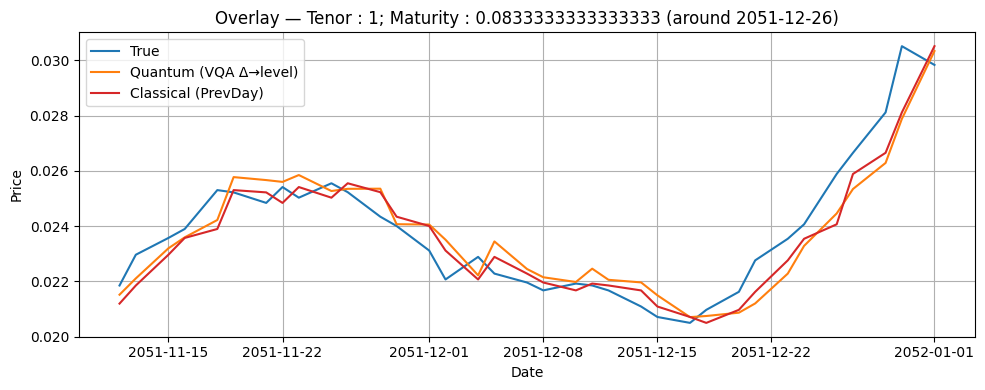

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_﻿Tenor _ 1; Maturity _ 0.0833333333333333_at_476.png


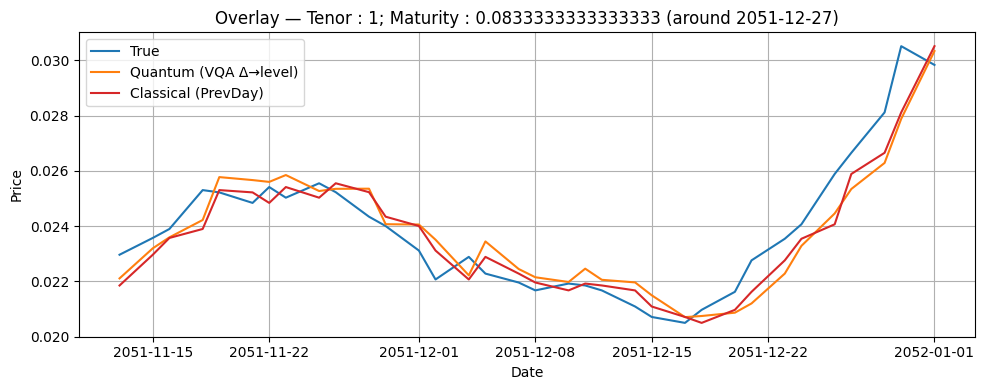

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_﻿Tenor _ 1; Maturity _ 0.0833333333333333_at_477.png


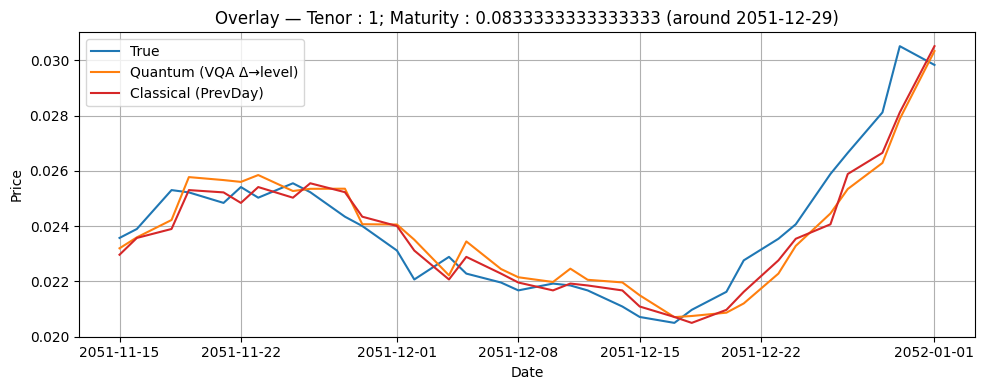

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_﻿Tenor _ 1; Maturity _ 0.0833333333333333_at_478.png


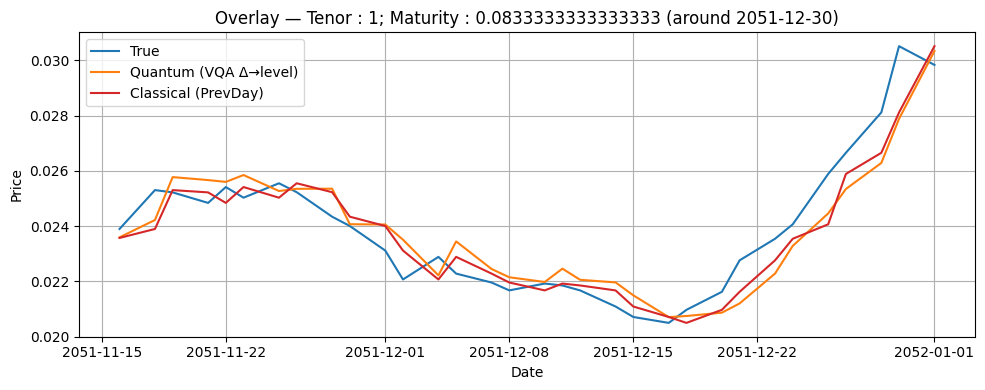

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_﻿Tenor _ 1; Maturity _ 0.0833333333333333_at_479.png


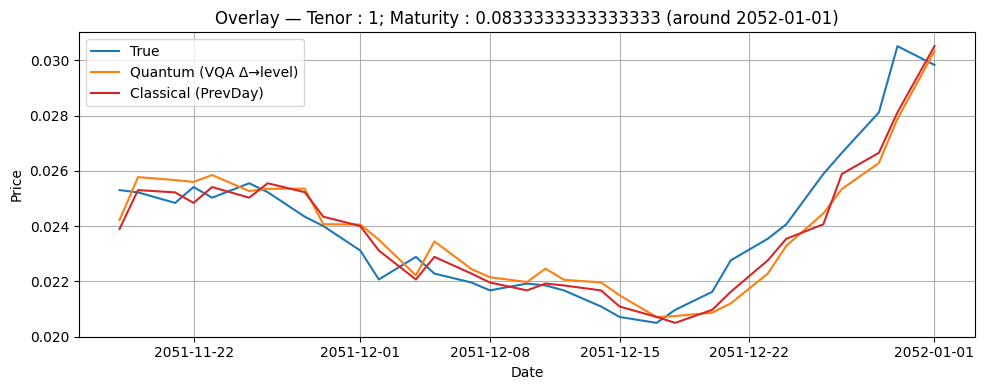

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 2; Maturity _ 0.0833333333333333_at_475.png


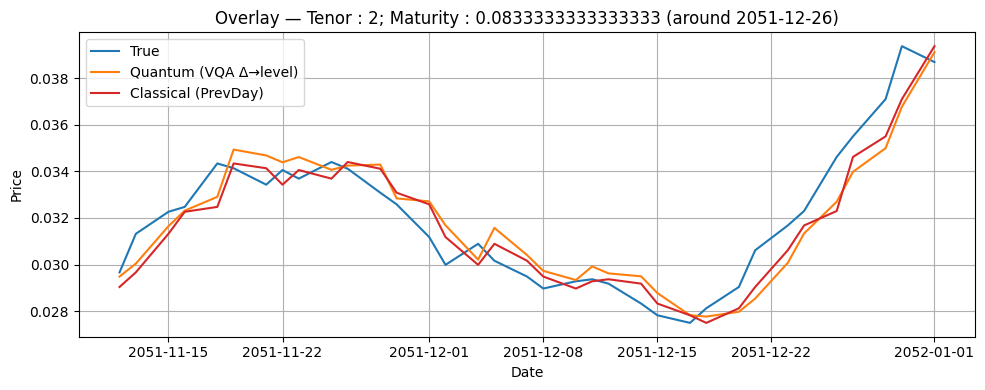

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 2; Maturity _ 0.0833333333333333_at_476.png


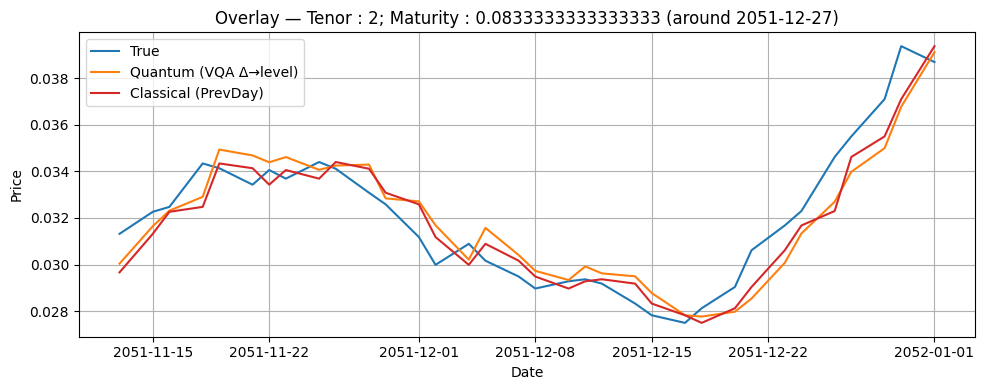

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 2; Maturity _ 0.0833333333333333_at_477.png


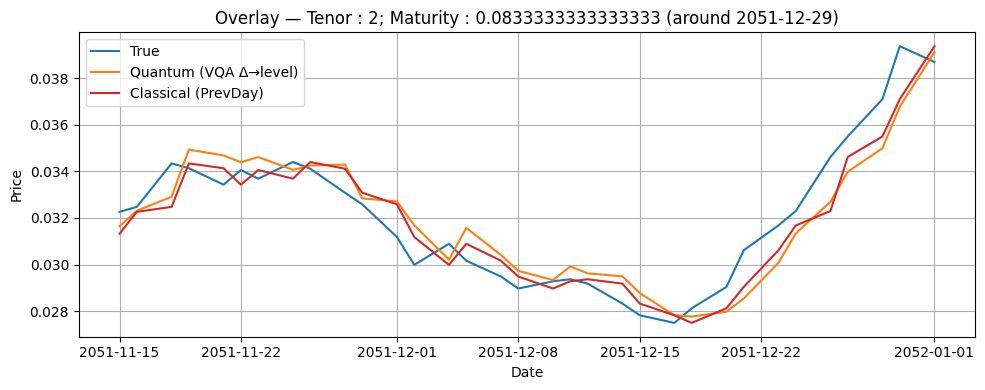

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 2; Maturity _ 0.0833333333333333_at_478.png


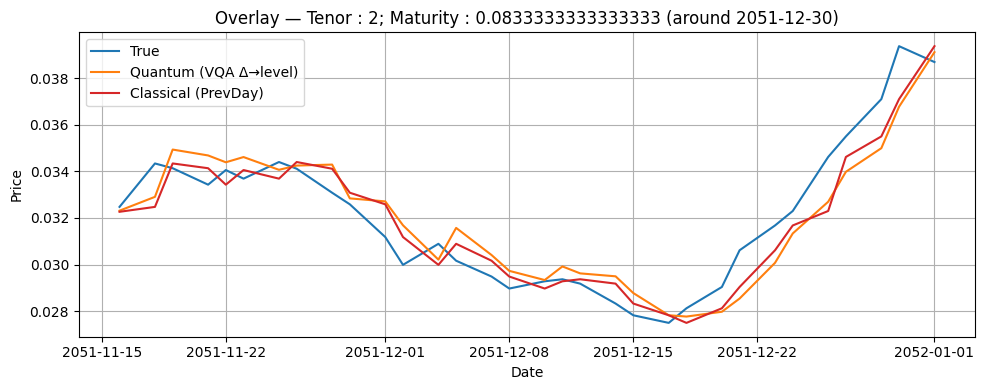

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 2; Maturity _ 0.0833333333333333_at_479.png


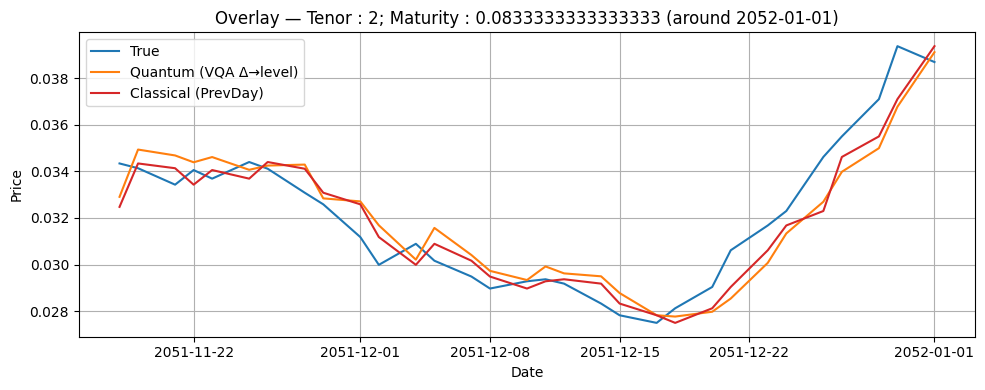

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 3; Maturity _ 0.0833333333333333_at_475.png


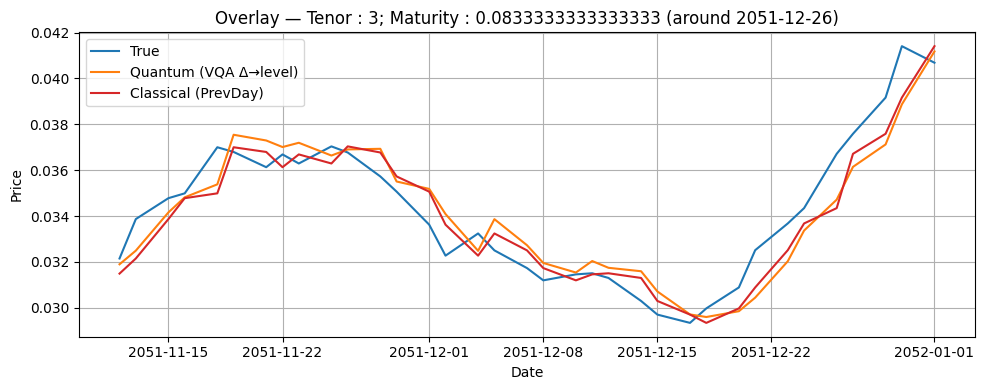

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 3; Maturity _ 0.0833333333333333_at_476.png


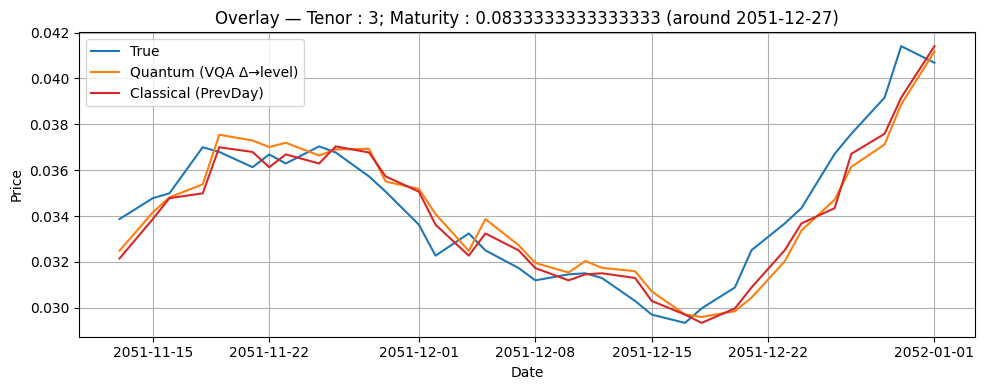

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 3; Maturity _ 0.0833333333333333_at_477.png


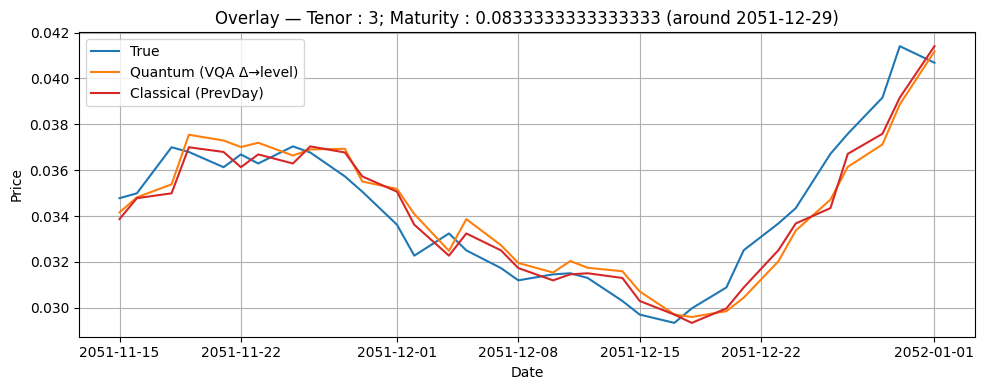

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 3; Maturity _ 0.0833333333333333_at_478.png


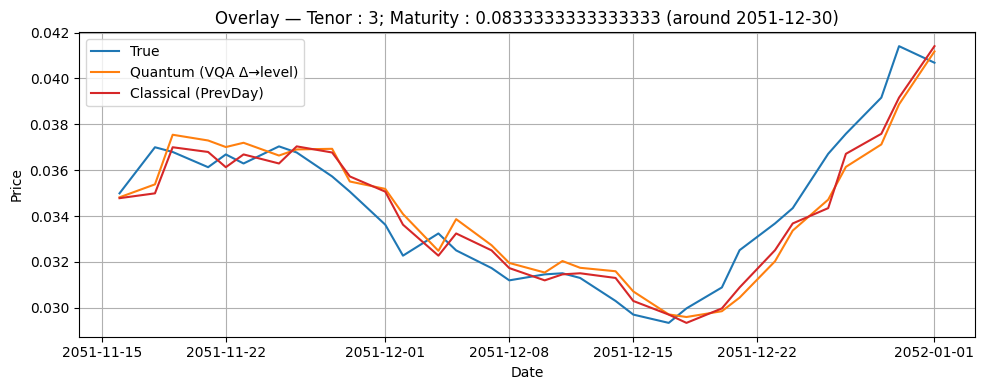

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_overlay_triple_Tenor _ 3; Maturity _ 0.0833333333333333_at_479.png


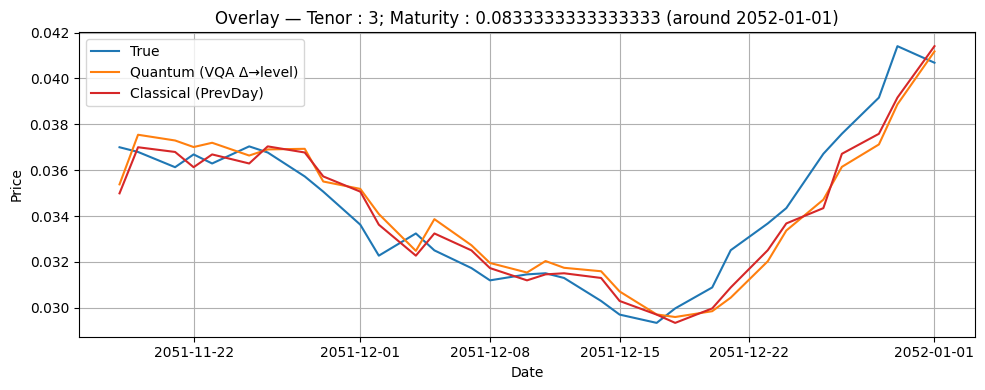

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_improve_heatmap_2051-12-26.png


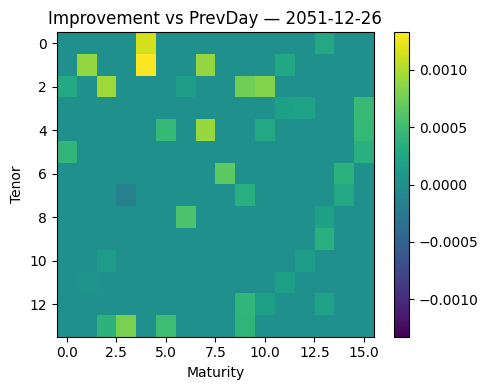

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_improve_heatmap_2051-12-27.png


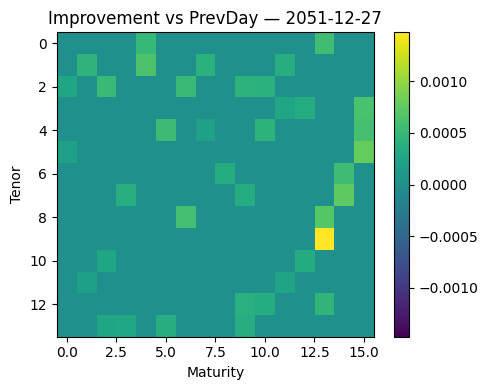

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_improve_heatmap_2051-12-29.png


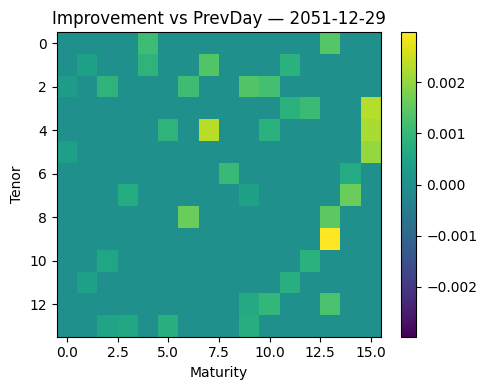

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_improve_heatmap_2051-12-30.png


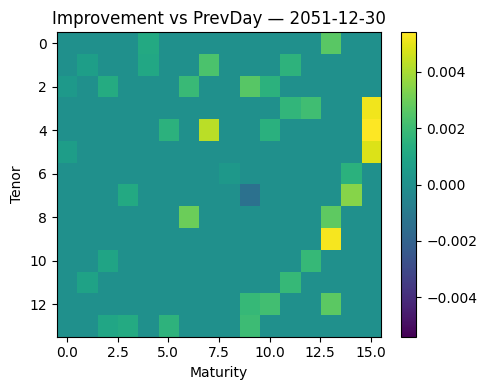

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_improve_heatmap_2052-01-01.png


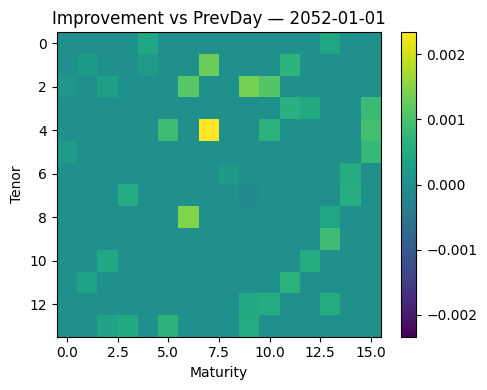

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_win_count_grid.png


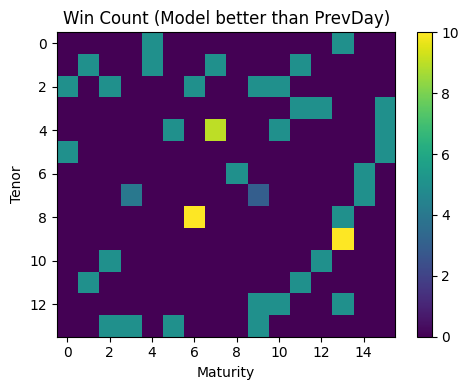


[Per-day average improvement]
      date  RMSE_prev  RMSE_model  improvement  improvement_pct
2051-12-26   0.004615    0.003385     0.001230         0.266325
2051-12-27   0.001889    0.000679     0.001210         0.640012
2051-12-29   0.003805    0.000755     0.003051         0.800348
2051-12-30   0.008042    0.002494     0.005548         0.688446
2052-01-01   0.002913    0.001274     0.001639         0.558222
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\table_goal1_perday_agg.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_bar_perday_rmse.png


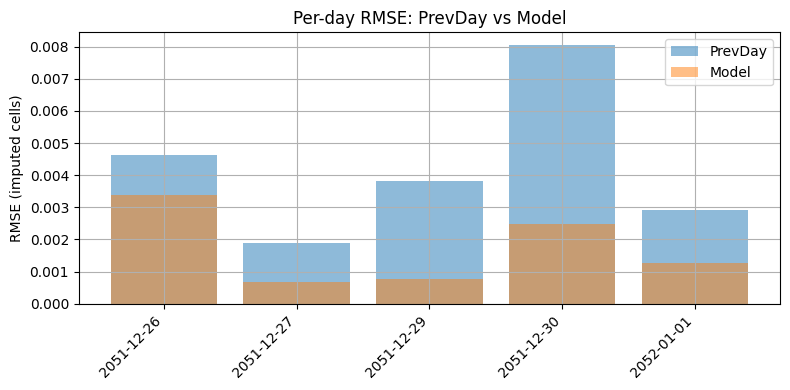

[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\fig_bar_improvement_pct.png


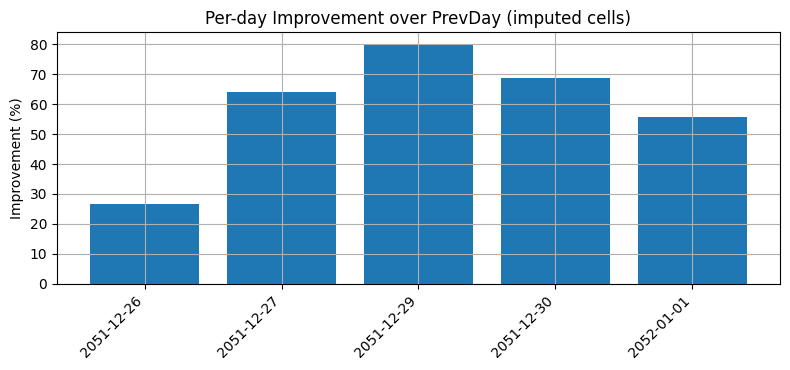


=== DONE (VQA Goal1 pipeline: Δ-only + GPR peer + day/local blend + evaluation & slide viz) ===


In [4]:
# ================================
# Cell 3 — Results & Slide-ready viz
# ================================
OUTDIR = ART["OUTDIR"]
dates_feat = ART["dates_feat"]
feature_cols = ART["feature_cols"]
target_rows = ART["target_rows"]
price_true_all = ART["price_true_all"]
price_vqa_all  = ART["price_vqa_all"]
baseline_full_price = ART["baseline_full_price"]
df_eval = ART["df_eval"]
per_day_improve = ART["per_day_improvement_vectors"]
improve_grid_count = ART["improve_grid_count"]
verdict = ART["verdict"]
goal1_pass = ART["goal1_pass"]

print("\n=== Goal 1 verdict ===")
print(f"PASS: {goal1_pass}")
print(f"Days improved fraction = {verdict['frac_days_improved']:.3f}")
print(f"Mean improvement pct   = {100*verdict['mean_impr_pct']:.2f}%")
print(f"Permutation p-value    = {verdict['p_value']:.4f}")

# ---- 1) サマリー ----
summary = pd.DataFrame({
    "Metric": ["Days improved fraction", "Mean improvement (%)", "Permutation p-value", "Goal 1 PASS?"],
    "Value":  [verdict['frac_days_improved'], 100*verdict['mean_impr_pct'], verdict['p_value'], goal1_pass]
})
print("\n[Goal 1 Summary]")
print(summary.to_string(index=False))
save_table(summary, os.path.join(OUTDIR, "table_goal1_summary.csv"))

# ---- 2) 3本オーバーレイ（±30日 × 上位3列 × 評価日）----
preview_span = 30
for jcol in range(min(3, len(feature_cols))):
    col = feature_cols[jcol]
    for r in target_rows:
        g_start = max(0, r - preview_span)
        g_end   = min(len(dates_feat)-1, r + preview_span)
        days = dates_feat[g_start:g_end+1]
        true_line = price_true_all[g_start:g_end+1, jcol]
        quantum_line = price_vqa_all[g_start:g_end+1, jcol]
        classical_line = baseline_full_price["PrevDay"][g_start:g_end+1, jcol]
        title = f"Overlay — {col} (around {str(dates_feat[r].date())})"
        out = os.path.join(OUTDIR, f"fig_overlay_triple_{col.replace(':','_')}_at_{r}.png")
        line_overlay_triple(days, true_line, quantum_line, classical_line,
                            labels=("True","Quantum (VQA Δ→level)","Classical (PrevDay)"),
                            title=title, out_png=out)

# ---- 3) 改善ヒートマップ（欠損セルのみの改善量; 日別）----
for day_str, lift_vec in per_day_improve.items():
    heatmap_by_grid(lift_vec, feature_cols, title=f"Improvement vs PrevDay — {day_str}", center_zero=True)
    savefig_show(os.path.join(OUTDIR, f"fig_improve_heatmap_{day_str}.png"))

# ---- 4) 勝率グリッド（モデルがPrevDayより勝った回数）----
heatmap_by_grid(improve_grid_count, feature_cols, title="Win Count (Model better than PrevDay)", center_zero=False)
savefig_show(os.path.join(OUTDIR, "fig_win_count_grid.png"))

# ---- 5) RMSEバー（PrevDay vs Model）----
agg = df_eval.groupby(["date"]).agg(
    RMSE_prev=("RMSE_PrevDay","mean"),
    RMSE_model=("RMSE_Model","mean"),
    RMSE_prev_sd=("RMSE_PrevDay","std"),
    RMSE_model_sd=("RMSE_Model","std"),
    improvement=("Improvement","mean"),
    improvement_pct=("Improvement_pct","mean")
).reset_index()
print("\n[Per-day average improvement]")
print(agg[["date","RMSE_prev","RMSE_model","improvement","improvement_pct"]].to_string(index=False))
save_table(agg, os.path.join(OUTDIR, "table_goal1_perday_agg.csv"))

plt.figure(figsize=(8,4))
plt.bar(agg["date"], agg["RMSE_prev"], alpha=0.5, label="PrevDay")
plt.bar(agg["date"], agg["RMSE_model"], alpha=0.5, label="Model")
plt.xticks(rotation=45, ha="right"); plt.ylabel("RMSE (imputed cells)")
plt.title("Per-day RMSE: PrevDay vs Model")
plt.legend(); plt.grid(True)
savefig_show(os.path.join(OUTDIR, "fig_bar_perday_rmse.png"))

plt.figure(figsize=(8,3.8))
plt.bar(agg["date"], 100*agg["improvement_pct"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Improvement (%)")
plt.title("Per-day Improvement over PrevDay (imputed cells)")
plt.grid(True)
savefig_show(os.path.join(OUTDIR, "fig_bar_improvement_pct.png"))

print("\n=== DONE (VQA Goal1 pipeline: Δ-only + GPR peer + day/local blend + evaluation & slide viz) ===")


In [5]:
# ================================
# Cell 4 — Global MSE Statistics (median-based)
# ================================
import os
import numpy as np
import pandas as pd

OUTDIR = ART["OUTDIR"]
df_eval = ART["df_eval"].copy()  # day×seedのRMSEなどが入っている集計テーブル

# 1) すべての RMSE_* 列から MSE_* 列を自動生成（例：RMSE_PrevDay → MSE_PrevDay）
rmse_cols = [c for c in df_eval.columns if c.startswith("RMSE_")]
if "RMSE_Model" not in rmse_cols:
    raise RuntimeError("df_eval に 'RMSE_Model' 列が見つかりません。Cell 2 の評価処理をご確認ください。")

for c in rmse_cols:
    mse_col = "MSE_" + c.split("RMSE_", 1)[1]
    df_eval[mse_col] = df_eval[c] ** 2

# 2) モデル（MSE_Model）と各ベースライン（MSE_*でModel以外）を比較
mse_model = df_eval["MSE_Model"].values
baseline_mse_cols = [c for c in df_eval.columns if c.startswith("MSE_") and c != "MSE_Model"]

rows = []
for bcol in baseline_mse_cols:
    base_name = bcol.replace("MSE_", "")  # 例: 'PrevDay' / 'TimeLinear' / 'ColMean' / 'Classical' など
    b = df_eval[bcol].values

    # NaN/inf を除外
    mask = np.isfinite(mse_model) & np.isfinite(b)
    if mask.sum() == 0:
        continue

    # 中央値 & MAD（中央値からの絶対偏差の中央値）
    med_m = float(np.nanmedian(mse_model[mask]))
    mad_m = float(np.nanmedian(np.abs(mse_model[mask] - med_m)))
    med_b = float(np.nanmedian(b[mask]))
    mad_b = float(np.nanmedian(np.abs(b[mask] - med_b)))

    # 勝率（MSEベース）：MSE_Model < MSE_Baseline の割合（%）
    win_rate = float((mse_model[mask] < b[mask]).mean() * 100.0)

    rows.append({
        "Baseline": base_name,
        "Model_MSE_median": med_m,
        "Model_MSE_MAD": mad_m,
        "Baseline_MSE_median": med_b,
        "Baseline_MSE_MAD": mad_b,
        "Win_rate(%)": win_rate,
        "N(day×seed)": int(mask.sum())
    })

stats_df = pd.DataFrame(rows).sort_values("Win_rate(%)", ascending=False).reset_index(drop=True)

print("=== Global MSE Statistics (median-based) ===")
if len(stats_df) == 0:
    print("比較対象のベースライン（RMSE_*）が見つかりませんでした。PrevDay 等の列をご確認ください。")
else:
    print(stats_df.to_string(index=False))

# 保存（全ベースライン分）
save_table(stats_df, os.path.join(OUTDIR, "table_global_mse_stats_median_by_baseline.csv"))

# 3) 互換の単純版（PrevDay専用の1行テーブル）も従来ファイル名で保存
if "MSE_PrevDay" in df_eval.columns:
    m = df_eval["MSE_Model"].values
    p = df_eval["MSE_PrevDay"].values
    mask = np.isfinite(m) & np.isfinite(p)

    median_mse_model = float(np.nanmedian(m[mask]))
    mad_mse_model    = float(np.nanmedian(np.abs(m[mask] - median_mse_model)))
    median_mse_prev  = float(np.nanmedian(p[mask]))
    mad_mse_prev     = float(np.nanmedian(np.abs(p[mask] - median_mse_prev)))
    win_rate_prev    = float((m[mask] < p[mask]).mean() * 100.0)

    print("\n--- (Compat) PrevDay vs Model ---")
    print(f"Model   MSE median = {median_mse_model:.6e}, MAD = {mad_mse_model:.6e}")
    print(f"PrevDay MSE median = {median_mse_prev:.6e}, MAD = {mad_mse_prev:.6e}")
    print(f"→ Model beats PrevDay in {win_rate_prev:.1f}% of (day×seed) cases")

    stats_prev = pd.DataFrame({
        "Metric":   ["MSE_median", "MSE_MAD", "Win_rate(%)"],
        "Model":    [median_mse_model, mad_mse_model, win_rate_prev],
        "PrevDay":  [median_mse_prev,  mad_mse_prev,  np.nan]
    })
    save_table(stats_prev, os.path.join(OUTDIR, "table_global_mse_stats_median.csv"))


=== Global MSE Statistics (median-based) ===
Baseline  Model_MSE_median  Model_MSE_MAD  Baseline_MSE_median  Baseline_MSE_MAD  Win_rate(%)  N(day×seed)
 PrevDay          0.000002       0.000001             0.000014          0.000007        100.0           15
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\table_global_mse_stats_median_by_baseline.csv

--- (Compat) PrevDay vs Model ---
Model   MSE median = 1.667206e-06, MAD = 1.310045e-06
PrevDay MSE median = 1.376674e-05, MAD = 6.847089e-06
→ Model beats PrevDay in 100.0% of (day×seed) cases
[SAVE] C:\qiskit-python\QFF2025\outputs\Missing_QRC\table_global_mse_stats_median.csv
